# Collaboration and Competition

---

In this notebook I train a pair of intelligent agents to collaborate with each other in a single environment. Each agent controls a single racket in a "tennis game" like environment and the goal of both the agents is to keep the ball in the air for as long as possible.

### 0. Import the Necessary Packages
Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from maddpg import MADDPG

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


### 1. Start the Environment

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Use MADDPG agents to play in this environment

In the next code cell, a pair of agents are trained using the [Multi Agent Deep Deterministic Policy Gradients algorithm (MADDPG)](https://arxiv.org/pdf/1706.02275.pdf) to play tennis within the environment. Their common goal is to keep the ball from touching the ground or being hit out of bounds for as long as possible.  
The score per episode is calculated as follows:
* The undiscounted rewards per time step are summed up for each individual agent.
* The score for the episode is the score of the agent with the higher score between the two.

In [5]:
m_agents = MADDPG(num_agents, state_size, action_size, 2)

Episode 100	Average Maximum Score: 0.00370
Episode 200	Average Maximum Score: 0.00810
Episode 300	Average Maximum Score: 0.03200
Episode 400	Average Maximum Score: 0.07690
Episode 500	Average Maximum Score: 0.11520
Episode 600	Average Maximum Score: 0.16140
Episode 700	Average Maximum Score: 0.35850
Episode 800	Average Maximum Score: 0.41120
Episode 900	Average Maximum Score: 0.49250
Episode 903	Maximum Score: 2.60
Environment solved in 803 episodes!	Average Score: 0.51550


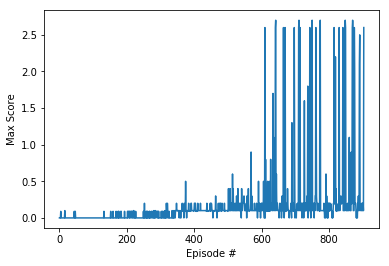

In [6]:
def maddpg(n_episodes=100000, print_every=100):
    
    scores_deque = deque(maxlen=print_every) # last 100 scores
    max_scores = []

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]          # reset the environment at episode start
        states = env_info.vector_observations                      # get the initial state (for each agent)
        m_agents.reset()                                           # reset the agents
        scores = np.zeros(num_agents)                              # initialize the score (for each agent)
        t = 0                                                      # variable to keep track of time step

        while True:
            t += 1
            actions = m_agents.act(states)                         # each agent acts based on its current policy
            actions = np.clip(actions, -1, 1)                      # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]               # send all actions to the environment
            next_states = env_info.vector_observations             # get next state (for each agent)
            rewards = env_info.rewards                             # get reward (for each agent)
            dones = env_info.local_done                            # see if episode finished
            scores += env_info.rewards                             # update the score (for each agent)
            m_agents.step(t, states, actions, rewards, next_states, dones) # perform a step in the agent
            states = next_states                                   # roll over states to next time step
            if np.any(dones):                                      # exit loop if episode finished
                break

        max_scores.append(max(scores))                             # take the maximum score of the two agents
        scores_deque.append(max(scores))                           

        print('\rEpisode {}\tMaximum Score: {:.2f}'.format(i_episode, max(scores)), end="")

        for index, agent in enumerate(m_agents.agents):
            torch.save(agent.actor_local.state_dict(), 'agent{}_checkpoint_actor.pth'.format(index+1))
            torch.save(agent.critic_local.state_dict(), 'agent{}_checkpoint_critic.pth'.format(index+1))

        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Maximum Score: {:.5f}'.format(i_episode, np.mean(scores_deque)))

        if np.mean(scores_deque) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.5f}'.format(i_episode-100, np.mean(scores_deque)))
            for index, agent in enumerate(m_agents.agents):
                torch.save(agent.actor_local.state_dict(), 'agent{}_checkpoint_actor.pth'.format(index+1))
                torch.save(agent.critic_local.state_dict(), 'agent{}_checkpoint_critic.pth'.format(index+1))
            break

    return max_scores

max_scores = maddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(max_scores)+1), max_scores)
plt.ylabel('Max Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [7]:
env.close()